## makemore: becoming a backprop ninja

aka backpropagation revisited on tensors

In [ ]:
# there no change change in the first several cells from last lecture

In [ ]:
# General Intro: Considers understanding bp fundamental to debug ANNs
# - See: https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b
# - Used to be done manually several years ago



In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
import random

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# ok biolerplate done, now we get to the action:

In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [43]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1 # set bias to small random values to break symmetry
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [44]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [72]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

# goal: manually implement the backward pass for every step here, and compare to PyTorch's autograd

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3204, grad_fn=<NegBackward0>)

In [54]:

# probs[0,0]

# logprobs[0,0]
# torch.reciprocal(probs[0,0])

# logits.exp()

torch.sum(counts, 1, keepdim=True).shape

dcounts_sum.shape

torch.Size([32, 1])

In [84]:
bndiff.shape

torch.Size([32, 64])

In [ ]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# assume simpler case (batchsize 3): loss = - (a + b + c) / 3 = -1/3a + -1/3b + -1/3c
# -> dloss / da = -1/3 (so for batch => 1/n)
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

dprobs = (1.0 / probs) * dlogprobs # using d(ln(x))/dx and chain rule
# Intuition: for examples with low probabilties it is boosting (1.0 / probs gets large) the gradient flow

# must be careful shapes are counts (32,27) and counts_sum_inv (32,1) so there is implicit broadcasting
# c= a * b, but with tensors:
# a [3x3] * b[3,1] ->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# c[3x3]
# Actually two operations
# 1. Replication allong columns -> can be considered as branching in computational graph -> final gradient sum of gradients of all branches -> sum
# 2. Multiplication -> bp: counts
# My error:
# Derivation: dprobs / dcounts_sum_inv_i = d(counts_j,k * counts_sum_inv_j) / dcounts_sum_inv_i = sum_k(counts_i,k)
# So came up with torch.sum(counts, 1, keepdim=True) * dprobs
# Remember: use atomic operations, so need to pull in chain rule into the sum
dcounts_sum_inv = torch.sum(counts * dprobs, 1, keepdim=True)

dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv  # dcounts_sum_inv / dcounts_sum = d(counts_sum**-1)/dcounts_sum

dcounts_branch1 = counts_sum_inv * dprobs # check matrix above, single multiplication as matrix a
# a11 a12 a13  ---> b1 (= a11 + a12 + a13)
# a21 a22 a23  ---> b2 (= a21 + a22 + a23)
# a31 a32 a33  ---> b3 (= a31 + a32 + a33)
# How much does b1 depend on a11, etc. -> 1
# Intuition for addition: in bp acts like a router distributing the gradient to each element of its sum equally
dcounts_branch2 = torch.ones_like(counts) * dcounts_sum # dcounts_sum / dcounts_i,j = d(sum_i (counts_i,j))) / dcounts_i,j = 1
dcounts = dcounts_branch1 + dcounts_branch2


# dnorm_logits = norm_logits.exp() * dcounts # dcounts / dnorm_logits = d(norm_logits.exp()) / dnorm_logits
dnorm_logits = counts * dcounts

# Careful: broadcasting in substraction in (norm_logits = logits - logit_maxes) norm_logits 32,27; logits 32,27; logit_maxes 32,1
# c11 c12 c13 = a11 a12 a13   b1
# c21 c22 c23 = a21 a22 a23 - b2
# c31 c32 c33 = a31 a32 a33   b3
# so e.g. c32 = a32 - b3 -> so derivative dnorm_logits / dlogits = 1 and dnorm_logits / dlogit_maxes = -1 (with additional summation for broadcasting)
dlogits_branch1 = torch.ones_like(logits) * dnorm_logits
dlogit_maxes = torch.sum(-1.0 * dnorm_logits, 1, keepdim=True)
# Comment: dlogit_maxes just for numerical stability, does not impact probs or loss -> check: gradient close to zero

dlogits_branch2 = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # dlogit_maxes / dlogits = dlogits.max(1, keepdim=True).values / dlogits = 1 at pos. of max
# Debug via: plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape [1]))
# Intuitively max plugs out the largest value at one position, at this location gradient simply one, i.e. scatter dlogit_maxes to position of maximums
dlogits = dlogits_branch1 + dlogits_branch2

# dlogits.shape 32,27, h.shape 32,64, W2.shape 64,27, b2.shape 27 (h @ W2 broadcasts!)
# From pen an paper example: 
# - can observe that dLoss / dh = dLoss / dlogits * @ b**T
# - dLoss / dW2 = a**T @ dLoss / dlogits
# - dLoss/ db = sum(0, dLoss / dlogits)
# - Taken together, gradient of matrix multiplication just a matrix multiplication
# - Karpathy hack: can also just use what makes sense and to match shapes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits 
db2 = dlogits.sum(0)

dhpreact = (1.0 - h **2) * dh  # dh / dhpreact = dtanh(hpreact) / dhpreact = 1 - tanh(hpreact)**2

# Careful: broadcasting again hpreact.shape 32,64, bngain.shape 1,64, bnraw.shape 32,64, bnbias.shape 1,64
dbngain = torch.sum(bnraw * dhpreact, 0, keepdim=True)  # dhpreact / dbngain = d(bngain * bnraw + bnbias) / dbngain = bnraw (broadcasted)
dbnbias = torch.sum(1.0 * dhpreact, 0, keepdim=True)  # dhpreact / dbnbias = d(bngain * bnraw + bnbias) / dbnbias = 1 (b)
dbnraw = bngain * dhpreact  # dhpreact / dbnraw = d(bngain * bnraw + bnbias) / dbnraw = bngain

# Careful: broadcasting again
dbndiff_branch1 = bnvar_inv * dbnraw
dbnvar_inv = torch.sum(bndiff * dbnraw, 0, keepdim=True)
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5 * 1.0) * dbnvar_inv # dbnvar_inv / dbnvar = d((bnvar + 1e-5)**-0.5) / dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 * 1.0
# bnvar 1,64: bndiff2 32,64
# General insights:
# - sum in forward -> broadcasting / replication in backward 
# - broadcasting / replication in forward -> sum in backward
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar # broadcasting
dbndiff_branch2 = 2.0 * bndiff * dbndiff2 
dbndiff = dbndiff_branch1 + dbndiff_branch2
dhprebn_branch1 = dbndiff.clone()
dbnmeani = torch.sum(-1.0 * dbndiff, 0, keepdim=True)

dhprebn_branch2 = (1.0/n) * torch.ones_like(hprebn) * dbnmeani # see dbndiff2 
dhprebn = dhprebn_branch1 + dhprebn_branch2

# Again, bp through linear layer: hprebn = embcat @ W1 + b1 # hidden layer pre-activation
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn 
db1 = dhprebn.sum(0)

# forward pass: embcat = emb.view (emb.shape (0], -1)
# embcat.shape 32,30, emb.shape 32, 3, 10 - simple concatenation or reinterpret
demb = dembcat.view(emb.shape)
# Plugout of embeddings: emb = C[Xb] (emb 32,3,10: C 27,10: Xb 32,3) -> rerout gradient to right assignments
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j] # collect all relevant derivatives
        

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

In [ ]:
# backward pass

# Analytically derived from single example (cave: we work with batches)
# Gradient p_i (softmax) for i != y and p_i - 1 for i = y
# For batches: batch loss is average loss per example (muss bp through this as well)

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n # for batch 

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.752088665962219e-09


In [ ]:
# intuition for dlogits
# - Derived from above that for single example, the gradient of the logits is actually the softmax with p_y - 1 for the label
# - E.g. for 4 class and true label 3, assume prediction probabilties (i.e. softmax) of (0.1 0.4 0.3 0.2), then the dlogits are (0.1 0.4 -0.7 0.2)
# - Hence, for an update, i.e. step into direction of -dlogits -> increase probability of true, decrease probability of wrong in proption of wrongness
# - This is zero-sum (like a force), where the attraction of true equal summed repulsion of false
# Overall: can consider NN as complicated pulley system with slight tug into a certain directions and parameters slowly give in

logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [99]:
# consider a first row of the logits
F.softmax(logits, 1)[0]

tensor([0.0741, 0.0933, 0.0179, 0.0503, 0.0191, 0.0833, 0.0253, 0.0343, 0.0177,
        0.0307, 0.0378, 0.0399, 0.0375, 0.0256, 0.0363, 0.0138, 0.0095, 0.0183,
        0.0153, 0.0512, 0.0467, 0.0212, 0.0256, 0.0718, 0.0593, 0.0236, 0.0205],
       grad_fn=<SelectBackward0>)

In [102]:
# consider the first row of the dlogits
dlogits[0] * n

tensor([ 0.0741,  0.0933,  0.0179,  0.0503,  0.0191,  0.0833,  0.0253,  0.0343,
        -0.9823,  0.0307,  0.0378,  0.0399,  0.0375,  0.0256,  0.0363,  0.0138,
         0.0095,  0.0183,  0.0153,  0.0512,  0.0467,  0.0212,  0.0256,  0.0718,
         0.0593,  0.0236,  0.0205], grad_fn=<MulBackward0>)

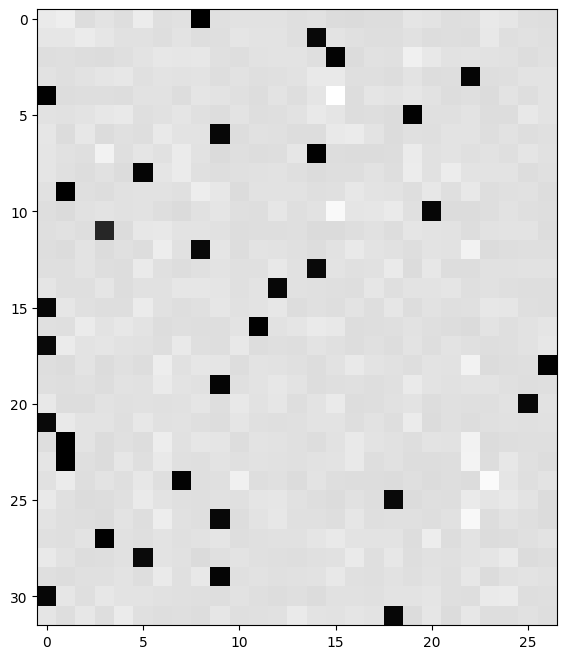

In [ ]:
# visualization of gradients dlogits
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)


# Formula derived analytically
# Putting in the formula is a problem in itself due to batch
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))


cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [106]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n # for batch 
    # 2nd layer
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits 
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h **2) * dh  # dh / dhpreact = dtanh(hpreact) / dhpreact = 1 - tanh(hpreact)**2
    # batchnorm
    dbngain = torch.sum(bnraw * dhpreact, 0, keepdim=True)  # dhpreact / dbngain = d(bngain * bnraw + bnbias) / dbngain = bnraw (broadcasted)
    dbnbias = torch.sum(1.0 * dhpreact, 0, keepdim=True)  # dhpreact / dbnbias = d(bngain * bnraw + bnbias) / dbnbias = 1 (b)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn 
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    # Plugout of embeddings: emb = C[Xb] (emb 32,3,10: C 27,10: Xb 32,3) -> rerout gradient to right assignments
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j] # collect all relevant derivatives

    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #   break

12297
      0/ 200000: 3.8438
  10000/ 200000: 2.1835
  20000/ 200000: 2.3848
  30000/ 200000: 2.4690
  40000/ 200000: 1.9572
  50000/ 200000: 2.3441
  60000/ 200000: 2.3886
  70000/ 200000: 2.0596
  80000/ 200000: 2.3725
  90000/ 200000: 2.0789
 100000/ 200000: 1.9135
 110000/ 200000: 2.2639
 120000/ 200000: 2.0010
 130000/ 200000: 2.4307
 140000/ 200000: 2.3107
 150000/ 200000: 2.1071
 160000/ 200000: 1.9669
 170000/ 200000: 1.8501
 180000/ 200000: 1.9865
 190000/ 200000: 1.9086


In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 4.190951585769653e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 2.2351741790771484e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [107]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [108]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0702321529388428
val 2.111553430557251


In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [109]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
amille.
khi.
mri.
reety.
skanden.
jazonel.
den.
arciereni.
nellara.
chaiiv.
kaleigh.
ham.
join.
quint.
shoine.
liven.
corathon.
jaryxia.
kael.
